In [1]:
import cv2
import h5py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import neuroglancer
import matplotlib.pyplot as plt

In [28]:
BATCH_SIZE = 10 # Size of batches
NUM_EPOCH = 10 # Number of training epochs
NUM_FILTERS = 64 # Number of input filters to the model (must be power of 2)
lr = .005 # Learning rate for training
SAMPLE_SHAPE = (32, 64, 64) # Adjust this parameter to change the shape of training/testing samples (each index must be power of 2)
CLIP_VALUE = .25 # Adjust this parameter on range [0,1] to control the clip value for gradient descent
IOU_WEIGHT = .00 # Set weight for IoU loss
DICE_WEIGHT = .750 # Set weight for Dice loss
BCE_WEIGHT = 1 - IOU_WEIGHT - DICE_WEIGHT # Set weight for BCE loss
THRESHOLD = 0.01 # Set target threshold for loss functions (very low due to small masks)
PORT = 9000 # Port for local diplay of segmented data (change to an unused port number)

In [3]:
# Use cuda computation if avaiable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# If cuda is avaiable, clear gpu cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print('cache cleared')
print(device)

cache cleared
cuda:0


In [4]:
# Retrieve local dataset
file_path = 'sample_A_20160501.hdf'
with h5py.File(file_path, 'r') as f:
    volume = f['volumes/raw'][:]
    labels = f['volumes/labels/clefts'][:]

In [5]:
# Convert files to float
labels = labels.astype(np.float32)
volume = volume.astype(np.uint8)
original_volume = volume

In [6]:
# Set all cleft masks to have value 1
labels[labels < 10000] = 1
# Set non-clefts (background) to value 0
labels[labels > 10000] = 0

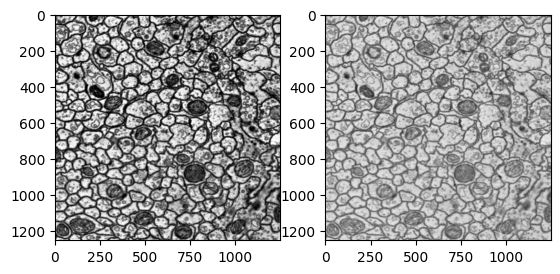

In [7]:
# Equalize the data
input_arr = volume
equilized_volume = np.zeros(input_arr.shape)

for z in range(input_arr.shape[0]):
    equilized_volume[z] = cv2.equalizeHist(input_arr[z].astype(np.uint8))
    
plt.subplot(121)
plt.imshow(equilized_volume[0], cmap='gray')
plt.subplot(122)
plt.imshow(input_arr[0], cmap='gray')

Generating Filter...


C:\Users\blake\AppData\Local\Temp\ipykernel_16312\3364888921.py:13: RuntimeWarning: invalid value encountered in divide
  volume_blur = input_arr[z] / volume_blur



50% Complete...

Completed


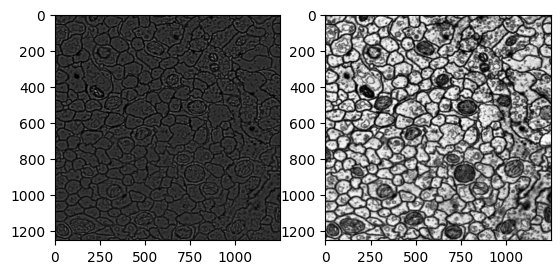

In [8]:
# Threshold the equalized data
kernel_size = 21

input_arr = equilized_volume
thresholded_volume = np.zeros(input_arr.shape)

print('Generating Filter...')

# Perform 3D adaptive thresholding for each channel
for z in range(input_arr.shape[0]):
    if z == (input_arr.shape[0]) // 2:
        print('\n50% Complete...') 
    volume_blur = cv2.GaussianBlur(input_arr[z], (kernel_size,kernel_size), kernel_size)
    volume_blur = input_arr[z] / volume_blur
    thresholded_volume[z] = (((volume_blur-volume_blur.min()) / float(volume_blur.max() - volume_blur.min())) * 255).astype(np.uint8)

print('\nCompleted')

plt.subplot(121)
plt.imshow(thresholded_volume[0], cmap='gray')
plt.subplot(122)
plt.imshow(input_arr[0], cmap='gray')

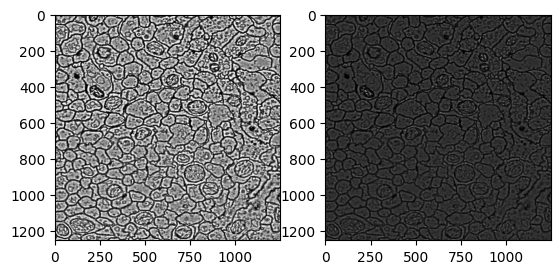

In [9]:
# Equalize the thresholded data
input_arr = thresholded_volume
equilized_volume = np.zeros(input_arr.shape)

for z in range(input_arr.shape[0]):
    equilized_volume[z] = cv2.equalizeHist(input_arr[z].astype(np.uint8))
        
plt.subplot(121)
plt.imshow(equilized_volume[0], cmap='gray')
plt.subplot(122)
plt.imshow(input_arr[0], cmap='gray')

In [10]:
# Apply canny egdge detection to the equalized data
input_arr = equilized_volume
canny_volume = np.zeros(input_arr.shape)

print('Applying Canny Edge Detection...')

for z in range(canny_volume.shape[0]):
    if z == (canny_volume.shape[0]) // 2:
        print('\n50% Complete...')
    canny_volume[z] = cv2.Canny(input_arr[z].astype(np.uint8), 80, 150)
    
print('\nCompleted')

plt.subplot(121)
plt.imshow(canny_volume[0], cmap='gray')
plt.subplot(122) 
plt.imshow(input_arr[0], cmap='gray')

Applying Canny Edge Detection...

50% Complete...

Completed


In [11]:
# Normalize the input data onto [0,1]
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    array = (array - min_val) / (max_val - min_val)
    return array

volume = normalize(equilized_volume) # Change the input to normalize to change pre-processing of the input data (currently set to not use canny edge detection)

In [12]:
# Generate subvolumes from original files
def extract_subvolumes(volume, label_volume, subvol_shape):
    subvolumes = []
    label_subvolumes = []
    for z in range(0, volume.shape[0], subvol_shape[0]):
        for y in range(0, volume.shape[1], subvol_shape[1]):
            for x in range(0, volume.shape[2], subvol_shape[2]):
                subvol = volume[z:z+subvol_shape[0], y:y+subvol_shape[1], x:x+subvol_shape[2]]
                label_subvol = label_volume[z:z+subvol_shape[0], y:y+subvol_shape[1], x:x+subvol_shape[2]]
                if subvol.shape == tuple(subvol_shape): 
                    subvolumes.append(subvol)
                    label_subvolumes.append(label_subvol)
    return subvolumes, label_subvolumes

In [35]:
volume_subvols, label_subvols = extract_subvolumes(volume, labels, SAMPLE_SHAPE)

In [14]:
# Split data into training, validation, and testing
train_volume, val_test_volume, train_label, val_test_label = train_test_split(volume_subvols, label_subvols, test_size=0.25, random_state=123)
val_volume, test_volume, val_label, test_label = train_test_split(val_test_volume, val_test_label, test_size=0.5, random_state=123)

In [15]:
# Custom dataloader (input must be list for transform to work)
class SubvolumeDataset(Dataset):
    def __init__(self, subvolumes, labels, transform=None):
        self.subvolumes = subvolumes
        self.labels = labels
        self.transform = transform
        if self.transform is not None:
            self.subvolumes = subvolumes * 5
            self.labels = labels * 5

    def __len__(self):
        return len(self.subvolumes)

    def __getitem__(self, idx):
        subvol_tensor = self.subvolumes[idx]
        label_subvol_tensor = self.labels[idx]
        subvol_tensor = torch.from_numpy(subvol_tensor)
        label_subvol_tensor = torch.from_numpy(label_subvol_tensor)
        if self.transform:
            transformed_labels, transformed_volume = self.transform(label_subvol_tensor, subvol_tensor)
            return transformed_volume, transformed_labels
        else:
            return subvol_tensor, label_subvol_tensor

In [16]:
# Apply random flipping and rotating to labels and volume
class Transformations(object):
    def __call__(self, labels, volume):
        transformed_labels, transformed_volume = self.apply_transformations(labels, volume)
        return transformed_labels, transformed_volume

    def apply_transformations(self, labels, volume):
        # Perform random transformations
        flip_lr = random.random() < 0.5  # Flip left-right
        flip_ud = random.random() < 0.5  # Flip up-down
        flip_fb = random.random() < 0.5  # Flip front-back

        # Apply flipping
        if flip_lr:
            labels = torch.flip(labels, dims=(2,))
            volume = torch.flip(volume, dims=(2,))
        if flip_ud:
            labels = torch.flip(labels, dims=(1,))
            volume = torch.flip(volume, dims=(1,))
        if flip_fb:
            labels = torch.flip(labels, dims=(0,))
            volume = torch.flip(volume, dims=(0,))

        # Randomly choose the number of rotations
        num_rotations = random.randint(0, 3)

        # Apply rotations
        for _ in range(num_rotations):
            labels = torch.rot90(labels, k=1, dims=(1, 2))
            volume = torch.rot90(volume, k=1, dims=(1, 2))

        return labels, volume

In [17]:
# Pre-process the data
transform = Transformations()
#transform = None

In [18]:
# Build Sub-Volume Dataset
train_subvol_dataset = SubvolumeDataset(train_volume, train_label, transform=transform)
test_subvol_dataset = SubvolumeDataset(test_volume, test_label, transform=transform)
val_subvol_dataset = SubvolumeDataset(val_volume, val_label, transform=transform)
      
# Load Data
train_loader = DataLoader(train_subvol_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subvol_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subvol_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
class Conv_Norm_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_Norm_ReLU, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.in1 = nn.InstanceNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.in2 = nn.InstanceNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.in1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.in2(x)
        x = self.relu2(x)
        return x

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = Conv_Norm_ReLU(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

    
class SynapseSegmentationModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_filters=64):
        super(SynapseSegmentationModel, self).__init__()
        self.inc = nn.Conv3d(in_channels, n_filters, kernel_size=3, padding=1)
        self.down1 = Conv_Norm_ReLU(n_filters, n_filters*2)
        self.down2 = Conv_Norm_ReLU(n_filters*2, n_filters*4)
        self.down3 = Conv_Norm_ReLU(n_filters*4, n_filters*8)
        self.down4 = Conv_Norm_ReLU(n_filters*8, n_filters*16)
        self.up1 = Up(n_filters*16, n_filters*8)
        self.up2 = Up(n_filters*8, n_filters*4)
        self.up3 = Up(n_filters*4, n_filters*2)
        self.up4 = Up(n_filters*2, n_filters)
        self.outc = nn.Conv3d(n_filters, out_channels, kernel_size=1)  
        self.activate = nn.Sigmoid()
    
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(F.max_pool3d(x1, 2))
        x3 = self.down2(F.max_pool3d(x2, 2))
        x4 = self.down3(F.max_pool3d(x3, 2))
        x5 = self.down4(F.max_pool3d(x4, 2))
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        mask = self.activate(x)
        return mask

In [20]:
# Instance the model
model = SynapseSegmentationModel(n_filters=NUM_FILTERS)
# Make model cuda compatable
model = model.to(device)

In [21]:
# Loss Functions
def iou_3d_loss(pred, target, threshold=THRESHOLD):
    pred = (pred > threshold).float()
    intersection = torch.logical_and(pred, target).sum(dim=[-3, -2, -1])
    union = torch.logical_or(pred, target).sum(dim=[-3, -2, -1])
    epsilon = 1e-5
    iou = (intersection + epsilon) / (union + epsilon)
    loss = 1.0 - iou.mean(dim=0)
    return loss

def dice_3d_loss(pred, target, threshold=THRESHOLD):
    pred = (pred > threshold).float()
    pred = pred.view(pred.shape[0], -1)
    target = target.view(target.shape[0], -1)
    intersection = torch.sum(pred * target, dim=0)
    union = torch.sum(pred, dim=0) + torch.sum(target, dim=0)
    epsilon = 1e-5
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    loss = 1.0 - dice
    return loss

criterion = nn.BCELoss()

In [22]:
# Optimization function
optimizer = optim.Adam(model.parameters(), lr=lr)

In [23]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCH):
    # Train the model for one epoch
    model.train()
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device).unsqueeze(1), targets.to(device).unsqueeze(1)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.float())
        outputs = outputs.to(device)
        
        # Compute the loss
        Dice_loss = dice_3d_loss(outputs, targets).mean()
        IoU_loss = iou_3d_loss(outputs, targets).mean()
        BCE_loss = criterion(outputs, targets).mean()
        loss = (BCE_loss * BCE_WEIGHT) + (IoU_loss * IOU_WEIGHT) + (Dice_loss * DICE_WEIGHT)
        loss = loss
        
        # Backward pass, gradient clipping, and optimization step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=CLIP_VALUE)
        optimizer.step()
        
        # Accumulate train loss
        train_loss += loss.item()

        # Print status
        if i % 10 == 9 or i+1 == len(train_loader.dataset):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE Loss: {:.4f}\tDice Loss: {:.6f}\tLoss: {:.4f}'.format(
                epoch+1, (i+1) * len(inputs), len(train_loader.dataset), 100. * (i+1) * len(inputs) / len(train_loader.dataset), 
                BCE_loss.item(), Dice_loss.item(), loss.item()))
            
    # Compute validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device).unsqueeze(1), targets.to(device).unsqueeze(1)
            outputs = model(inputs.float())
            outputs = outputs.to(device)
            IoU_loss = iou_3d_loss(outputs, targets).mean() * IOU_WEIGHT
            Dice_loss = dice_3d_loss(outputs, targets).mean() * DICE_WEIGHT
            BCE_loss = criterion(outputs, targets).mean() * BCE_WEIGHT 
            loss = IoU_loss + Dice_loss + BCE_loss
            val_loss += loss.item()

    # Average train and validation loss
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    
    # Store train and validation losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print epoch summary
    print('\nEpoch: {} Train Loss: {:.6f} Val Loss: {:.6f}\n'.format(epoch+1, train_loss, val_loss))
            
# Save final trained model
with open(f"final_trained_synapse_model.pth", "wb") as f:
    torch.save(model.state_dict(), f)

print("Finished Training")

Train Epoch: 1 [100/4060 (2%)]	BCE Loss: 0.2254	Dice Loss: 0.999999	Loss: 0.8063
Train Epoch: 1 [200/4060 (5%)]	BCE Loss: 0.1009	Dice Loss: 0.983450	Loss: 0.7628
Train Epoch: 1 [300/4060 (7%)]	BCE Loss: 0.0666	Dice Loss: 0.983431	Loss: 0.7542
Train Epoch: 1 [400/4060 (10%)]	BCE Loss: 0.0232	Dice Loss: 0.999873	Loss: 0.7557
Train Epoch: 1 [500/4060 (12%)]	BCE Loss: 0.0248	Dice Loss: 0.995564	Loss: 0.7529
Train Epoch: 1 [600/4060 (15%)]	BCE Loss: 0.0142	Dice Loss: 0.998771	Loss: 0.7526
Train Epoch: 1 [700/4060 (17%)]	BCE Loss: 0.0177	Dice Loss: 0.989443	Loss: 0.7465
Train Epoch: 1 [800/4060 (20%)]	BCE Loss: 0.0213	Dice Loss: 0.945486	Loss: 0.7144
Train Epoch: 1 [900/4060 (22%)]	BCE Loss: 0.0086	Dice Loss: 0.909191	Loss: 0.6840
Train Epoch: 1 [1000/4060 (25%)]	BCE Loss: 0.0130	Dice Loss: 0.747025	Loss: 0.5635
Train Epoch: 1 [1100/4060 (27%)]	BCE Loss: 0.0089	Dice Loss: 0.644827	Loss: 0.4859
Train Epoch: 1 [1200/4060 (30%)]	BCE Loss: 0.0636	Dice Loss: 0.532651	Loss: 0.4154
Train Epoch: 1 [

In [24]:
#Testing
# Define a function to compute the accuracy
def compute_accuracy(predictions, labels):
    # Compute the number of correct predictions
    num_correct = (predictions == labels).sum().item()
    # Compute the total number of predictions
    num_total = labels.numel()
    # Compute the accuracy
    accuracy = num_correct / num_total
    return accuracy

# Evaluate the model on the test set
model = SynapseSegmentationModel(n_filters=NUM_FILTERS)

# Load the saved state dictionary
state_dict = torch.load("final_trained_synapse_model.pth")

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()
total_accuracy = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device).unsqueeze(1)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs.float())
        # Convert the outputs to class predictions
        outputs[outputs < THRESHOLD] = 0
        outputs[outputs >= THRESHOLD] = 1
        # Compute the accuracy for this batch and add it to the total accuracy
        batch_accuracy = compute_accuracy(outputs, targets)
        total_accuracy += batch_accuracy * inputs.shape[0]  # multiply by batch size
    # Divide by the total number of examples to get the overall accuracy
    total_accuracy /= (len(test_subvol_dataset)*BATCH_SIZE) 

print(f"Test accuracy: {total_accuracy:.6f}")

Test accuracy: 0.986855


In [36]:
# Build segmentation mask (sliding window)

# Initialize the model
trained_model = SynapseSegmentationModel(n_filters=NUM_FILTERS)
# Load the saved state dictionary
state_dict = torch.load("final_trained_synapse_model.pth")
# Load the state dictionary into the model
trained_model.load_state_dict(state_dict)
# Make model cuda compatable
trained_model = trained_model.to(device)
# Set evaluation mode
trained_model.eval()

# Set patch size
patch_size = SAMPLE_SHAPE

# Initialize segmentation mask
segmentation_mask = np.zeros(volume.shape, dtype=np.uint8)

print('Generating Mask...')

# Iterate over the large array and get a patch
for z in range(0, volume.shape[0], patch_size[0]):
    for y in range(0, volume.shape[1], patch_size[1]):
        for x in range(0, volume.shape[2], patch_size[2]):
            patch = volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]
            if patch.shape == tuple(patch_size): # Check that patch is correct shape
                # Pre-process the patch
                patch = normalize(patch)
            
                # Convert the patch to a tensor and add a batch dimension
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)

                # Perform segmentation inference on the patch
                with torch.no_grad():
                    prediction = trained_model(patch_tensor.float())
               
                # Post-process
                prediction[prediction < THRESHOLD] = 0
                prediction[prediction >= THRESHOLD] = 1
            
                # Convert prediction to a numpy array
                prediction = prediction.squeeze().squeeze().cpu().detach().numpy()
                
                # Reconstruct segmentation mask
                segmentation_mask[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] = prediction

print('Finished Mask Generation')

print('\nSaving mask...')

# Save the mask as an h5py file
with h5py.File('segmentation_mask.hdf', 'w') as f:
    f.create_dataset('data', data=segmentation_mask)
    
print('Save Complete')

Generating Mask...
Finished Mask Generation

Saving mask...
Save Complete


In [34]:
# View segmented mask on the raw data
ip = 'localhost' # Or public IP of the machine for sharable display
port = PORT
neuroglancer.set_server_bind_address(bind_address=ip,bind_port=port)
viewer=neuroglancer.Viewer()

# Raw image data
raw = original_volume

print('Loading mask...')
# Load the segmentation mask
with h5py.File('segmentation_mask.hdf', 'r') as f:
    # Access the dataset
    seg = f['data'][:]
    # Load the dataset into a NumPy array
    seg = seg[()]

# Make sure the mask and raw data have the same shape 
print('\nRaw Image Shape: ', raw.shape, '\nMask Shape: ', seg.shape, '\n')

res = neuroglancer.CoordinateSpace(
        names=['z', 'y', 'x'],
        units=['nm', 'nm', 'nm'],
        scales=[1, 1, 1])

def ngLayer(data,res,oo=[0,0,0],tt='segmentation'):
    return neuroglancer.LocalVolume(data,dimensions=res,volume_type=tt,voxel_offset=oo)

with viewer.txn() as s:
    s.layers.append(name='raw',layer=ngLayer(raw,res,tt='image'))
    s.layers.append(name='seg',layer=ngLayer(seg,res,tt='segmentation'))

print(viewer)

Loading mask...

Raw Image Shape:  (125, 1250, 1250) 
Mask Shape:  (125, 1250, 1250) 

http://localhost:9000/v/382e711246075ab987cdbdc269e060f3de506172/
